In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import datetime
import glob
import os

%matplotlib inline

In [2]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.manual_seed(random_seed)

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [3]:
#  torchvision.transforms.Normalize(
#    (0.1307,), (0.3081,))

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=True, pin_memory=True)

0it [00:00, ?it/s]

9920512it [00:02, 4822131.04it/s]                            


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 141885.80it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2321112.49it/s]                            
0it [00:00, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51793.32it/s]            


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.dens1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        self.dens2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        self.dens3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
        self.dens4 = nn.Linear(64, 20)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)
        self.dens5 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dens1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.dens2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.dens3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.dens4(x)
        x = self.relu4(x)
        x = self.drop4(x)
        x = self.dens5(x)
        return F.log_softmax(x, dim=1)
    
    def extract_outputs(self, data, layer, neuron=None):
        outputs = []      
        def hook(module, input, output):
            outputs.append(output)    
        for name, module in self.named_children():
            if name == layer:
                handle = module.register_forward_hook(hook)     
        out = self(data)
        if not neuron is None:
            outputs[0] = outputs[0][0][neuron]
        else:
            outputs[0] = outputs[0][0]
        handle.remove()
        return torch.stack(outputs)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = self.relu2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def extract_outputs(self, data, layer, neuron=None):
        outputs = []      
        def hook(module, input, output):
            outputs.append(output)    
        for name, module in self.named_children():
            if name == layer:
                handle = module.register_forward_hook(hook)     
        out = self(data)
        if not neuron is None:
            outputs[0] = outputs[0][0][neuron]
        else:
            outputs[0] = outputs[0][0]
        handle.remove()
        return torch.stack(outputs)
  
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # calculate robust loss
        loss = F.cross_entropy(model(data), target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check to see if we can just load a previous model
%mkdir models
latest_model = None
m_type = model.__class__.__name__
prev_models = glob.glob('/content/models/*'+ m_type +'*.pth')
if prev_models:
    latest_model = max(prev_models, key=os.path.getctime)

if latest_model is not None and m_type in latest_model:
    print('loading model', latest_model)
    model.load_state_dict(torch.load(latest_model))  
else:
    for epoch in range(1, n_epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)    
    torch.save(model.state_dict(), '/content/models/model_' + m_type + '_' +str(datetime.datetime.now()).replace(':','.') + '.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301512
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.191104
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.806484
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.701382
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.419531
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.603290
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.135957
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.227602
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.336506
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.158178

Test set: Average loss: 0.1832, Accuracy: 9451/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.309578
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.161466
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.109582
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.126139
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.201897
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.079430
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.102752
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.057112
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.056694
T

# Attack Time

In [0]:
def atanh(x, eps=1e-2):
    """
    The inverse hyperbolic tangent function, missing in pytorch.

    :param x: a tensor or a Variable
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))

def to_tanh_space(x, box=box):
    """
    Convert a batch of tensors to tanh-space. This method complements the
    implementation of the change-of-variable trick in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in tanh-space, of the same dimension;
             the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return atanh((x - _box_plus) / _box_mul)

def from_tanh_space(x, box=box):
    """
    Convert a batch of tensors from tanh-space to oridinary image space.
    This method complements the implementation of the change-of-variable trick
    in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in ordinary image space, of the same
             dimension; the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return torch.tanh(x) * _box_mul + _box_plus
  
def compensate_confidence(outputs, targets):
    """
    Compensate for ``self.confidence`` and returns a new weighted sum
    vector.

    :param outputs: the weighted sum right before the last layer softmax
           normalization, of dimension [B x M]
    :type outputs: np.ndarray
    :param targets: either the attack targets or the real image labels,
           depending on whether or not ``self.targeted``, of dimension [B]
    :type targets: np.ndarray
    :return: the compensated weighted sum of dimension [B x M]
    :rtype: np.ndarray
    """
    outputs_comp = outputs.clone()
    rng = torch.range(start=0, end=targets.shape[0]-1, dtype=torch.long, device=device)
    # targets = targets.int()
    if targeted:
        # for each image $i$:
        # if targeted, `outputs[i, target_onehot]` should be larger than
        # `max(outputs[i, ~target_onehot])` by `self.confidence`
        outputs_comp[rng, targets] -= confidence
    else:
        # for each image $i$:
        # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
        # than `outputs[i, target_onehot]` (the ground truth image labels)
        # by `self.confidence`
        outputs_comp[rng, targets] += confidence
    return outputs_comp
  
def attack_successful(prediction, target):
    """
    See whether the underlying attack is successful.

    :param prediction: the prediction of the model on an input
    :type prediction: int
    :param target: either the attack target or the ground-truth image label
    :type target: int
    :return: ``True`` if the attack is successful
    :rtype: bool
    """
    if targeted:
        return prediction == target
    else:
        return prediction != target
      
def norm_divergence(data, model, layer, neuron=None, regularizer_weight=None):
    """
    returns the kld between the activations of the specified layer and a uniform pdf
    """
    # extract layer activations as numpy array
    layer_activations = model.extract_outputs(data=data, layer=layer)
    
    # normalize with softmax (to get a probability density)
    out_norm = torch.sum(layer_activations, 0)
    out_norm = F.softmax(out_norm, 0)

    # create uniform tensor
    uniform_tensor = torch.FloatTensor(*out_norm.shape).uniform_(0., 1.).to(device)

    # normalize over summation (to get a probability density)
    uni_norm = uniform_tensor/torch.sum(uniform_tensor)
    
    # measure divergence between normalized layer activations and uniform distribution
    divergence = F.kl_div(input=out_norm.log(), target=uni_norm, reduction='sum')
    
    # default regularizer if not provided
    if regularizer_weight is None:
        regularizer_weight = 0.005 
    
    return regularizer_weight * divergence

In [0]:
# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

In [0]:
def cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                 c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                 abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                 init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`          : the least L2 norms
    # - `o_best_l2_ppred`    : the perturbed predictions made by the adversarial perturbations with the least L2 norms
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_l2_ppred`
    o_best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step)

        # the minimum L2 norms of perturbations found during optimization
        best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least L2 norms
        best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device)

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)

            # Calculate L2 norm between adversaries and original inputs
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

            # the total loss of current batch, should be of dimension [1]
            batch_loss = torch.sum(pert_norms + scale_consts * f)

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {}'.format(optim_step, batch_loss))

            if abort_early and not optim_step % (max_steps // 10):   
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                l2 = pert_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if l2 < best_l2[i]:
                        best_l2[i] = l2
                        best_l2_ppred[i] = ppred
                    if l2 < o_best_l2[i]:
                        o_best_l2[i] = l2
                        o_best_l2_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_l2_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries

In [0]:
targeted=False
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=10
max_steps=1000
abort_early=True
optimizer_lr=5e-4

mean = (0.1307,) # the mean used in inputs normalization
std = (0.3081,) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

log_frequency = 100

In [15]:
cw_advs = cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                       c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                       abort_early=True, box=box, optimizer_lr=1e-2, 
                       init_rand=False, log_frequency=100)

Step 0
batch [0] loss: 10.415900230407715
batch [100] loss: 0.7689923644065857
batch [200] loss: 0.768934965133667
Step 1
batch [0] loss: 7.684222221374512
batch [100] loss: 7.638064384460449
batch [200] loss: 7.638099193572998
Step 2
batch [0] loss: 75.86489868164062
batch [100] loss: 71.02244567871094
batch [200] loss: 71.02180480957031
Step 3
batch [0] loss: 653.8789672851562
batch [100] loss: 258.825927734375
batch [200] loss: 256.5467529296875
batch [300] loss: 255.69586181640625
batch [400] loss: 255.42002868652344
batch [500] loss: 254.77783203125
batch [600] loss: 255.2265625
Step 4
batch [0] loss: 359.650146484375
batch [100] loss: 242.97149658203125
batch [200] loss: 244.4771728515625


Perturbed Accuracy: 0/100 (0%)

Original Accuracy: 98/100 (98%)



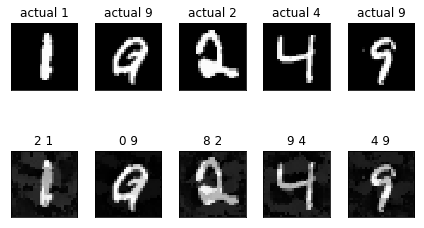

In [16]:
pert_output = model(cw_advs)
orig_output = model(inputs)

pert_pred = torch.argmax(pert_output, dim=1)
orig_pred = torch.argmax(orig_output, dim=1)

pert_correct = pert_pred.eq(targets.data).sum()
orig_correct = orig_pred.eq(targets.data).sum()

pert_acc = 100. * pert_correct / len(targets)
orig_acc = 100. * orig_correct / len(targets)

print('Perturbed Accuracy: {}/{} ({:.0f}%)\n'.format(pert_correct, len(targets), pert_acc))
print('Original Accuracy: {}/{} ({:.0f}%)\n'.format(orig_correct, len(targets), orig_acc))

adversarial_examples = o_best_adversaries.cpu().detach().numpy()
input_examples = inputs.cpu().detach().numpy()

# inputs, adversarial_examples, targets
num_samples = 5

for i in range(1,num_samples+1):
    
    plt.subplot(2, num_samples, i)
    plt.imshow(np.squeeze(input_examples[i]), cmap='gray')  
    plt.title('actual {}'.format(targets[i].item()))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, num_samples, num_samples+i)
    plt.imshow(np.squeeze(adversarial_examples[i]), cmap='gray')
    plt.title('{} {}'.format(pert_pred[i].item(), orig_pred[i].item()))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

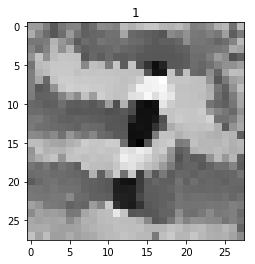

In [0]:
plt.imshow((o_best_adversaries[1] - inputs[1]).cpu().detach().numpy().reshape(28,28), cmap='gray') 
plt.title(targets[1].cpu().numpy())
plt.show()

# Diversity Attack

In [0]:
def cw_div_attack(model, inputs, targets, targeted=False, confidence=0.0,
                  c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                  abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                  init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step)

        # the minimum divergences of perturbations found during optimization
        best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least divergences
        best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device)

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)

            # calculate kl divergence for each input
            divs = []
            for i in range(batch_size):
                divs.append(norm_divergence(data=adversaries[i].unsqueeze(0), model=model, layer='relu3', regularizer_weight=1))

            div_norms = torch.tensor(torch.stack(divs), device=device)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

    #         # diversity regularizer
    #         diversity_reg = norm_divergence(data=adversaries, model=model, layer='relu3', regularizer_weight=1)

            # the total loss of current batch, should be of dimension [1]
            batch_loss = torch.sum(scale_consts * f + div_norms) # + diversity_reg

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {}'.format(optim_step, batch_loss))

            if abort_early and not optim_step % (max_steps // 10):   
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                div = div_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if div < best_div[i]:
                        best_div[i] = div
                        best_div_ppred[i] = ppred
                    if div < o_best_div[i]:
                        o_best_div[i] = div
                        o_best_div_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_div_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries

In [21]:
cw_advs_div = cw_div_attack(model, inputs, targets, targeted=False, confidence=0.0,
                            c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                            abort_early=True, box=box, optimizer_lr=1e-2, 
                            init_rand=False, log_frequency=100)

Step 0
batch [0] loss: 135.1306915283203
batch [100] loss: 125.01528930664062
batch [200] loss: 124.4491958618164
batch [300] loss: 124.50749969482422
Step 1
batch [0] loss: 124.57865142822266
batch [100] loss: 124.82147216796875
Step 2
batch [0] loss: 125.05036926269531
batch [100] loss: 124.69972229003906
batch [200] loss: 124.65570831298828
batch [300] loss: 124.74939727783203
Step 3
batch [0] loss: 124.8875732421875
batch [100] loss: 124.60482788085938


RuntimeError: ignored

In [0]:
pert_output = model(cw_advs_div)
orig_output = model(inputs)

pert_pred = torch.argmax(pert_output, dim=1)
orig_pred = torch.argmax(orig_output, dim=1)

pert_correct = pert_pred.eq(targets.data).sum()
orig_correct = orig_pred.eq(targets.data).sum()

pert_acc = 100. * pert_correct / len(targets)
orig_acc = 100. * orig_correct / len(targets)

print('Perturbed Accuracy: {}/{} ({:.0f}%)\n'.format(pert_correct, len(targets), pert_acc))
print('Original Accuracy: {}/{} ({:.0f}%)\n'.format(orig_correct, len(targets), orig_acc))

adversarial_examples = o_best_adversaries.cpu().detach().numpy()
input_examples = inputs.cpu().detach().numpy()

# inputs, adversarial_examples, targets
num_samples = 5

for i in range(1,num_samples+1):
    
    plt.subplot(2, num_samples, i)
    plt.imshow(np.squeeze(input_examples[i]), cmap='gray')  
    plt.title('actual {}'.format(targets[i].item()))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, num_samples, num_samples+i)
    plt.imshow(np.squeeze(adversarial_examples[i]), cmap='gray')
    plt.title('{} {}'.format(pert_pred[i].item(), orig_pred[i].item()))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()